# Machine Learning Models Predicting Annual Salary


### 2023 Developer Survey conducted by Stack Overflow

In May 2023 over 90,000 developers responded to the annual survey about how they learn and level up, which tools they're using, and which ones they want. Here we explore developer profile and programming, scripting, and markup languages developers used in 2023. The goal is to figure out high-paying professionals and their programming preferences.

### Data Dictionary

`MainBranch` - Which of the following options best describes you today? For the purpose of this survey, a developer is "someone who writes code".

`Age` - What is your age?

`Employment` - Which of the following best describes your current employment status? Select all that apply.

`RemoteWork` - Which best describes your current work situation?

`EdLevel` - Which of the following best describes the highest level of formal education that you’ve completed?

`YearsCode` - Including any education, how many years have you been coding in total?

`YearsCodePro` - NOT including education, how many years have you coded professionally (as a part of your work)?

`DevType` - Which of the following describes your current job, the one you do most of the time? Please select only one.

`Country` - Where do you live?

`ConvertedCompYearly` -  What is your current total annual compensation (salary, bonuses, and perks, before
taxes and deductions)? We converted salaries from user currencies to USD using the exchange rate on June 2, 2023.

`LanguageHaveWorkedWith` - Which programming, scripting, and markup languages have you done extensive development work in over the past year?

`ICorPM` - Are you an individual contributor or people manager?

`WorkExp` - How many years of working experience do you have?

`Industry` - What industry is the company you work for in?

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import sys
sys.path.append("../src")

from config import url2023, url2024, file_name
from data.load_data import get_data
from data.clean_data import dataset_cleaned, dataset_cleaned1

# load row data
df = get_data(url2023, file_name)

# cleaned subset of the data
cdf = dataset_cleaned1(df)

In [3]:
cdf.head(5)

,EdLevel,YearsCodePro,LanguageHaveWorkedWith,NLanguageHaveWorkedWith,DevType,Country,Region,ConvertedCompYearly,ICorPM,WorkExp,Industry
0,Bachelor,9.0,HTML/CSS;JavaScript;Python,3.0,"Senior Executive (C-Suite, VP, etc.)",United States of America,Northern America,285000.0,People manager,10.0,"Information Services, IT, Software Development..."
1,Bachelor,23.0,Bash/Shell (all shells);Go,2.0,"Developer, back-end",United States of America,Northern America,250000.0,Individual contributor,23.0,"Information Services, IT, Software Development..."
2,Bachelor,4.0,HTML/CSS;JavaScript;TypeScript,3.0,"Developer, full-stack",Philippines,South-eastern Asia,23456.0,Individual contributor,6.0,Other
3,Non-graduated,21.0,Bash/Shell (all shells);HTML/CSS;JavaScript;Ru...,6.0,"Developer, back-end",United Kingdom of Great Britain and Northern I...,Northern Europe,96828.0,Individual contributor,22.0,Other
4,Non-graduated,3.0,Ada;Clojure;Elixir;Go;HTML/CSS;Java;JavaScript...,15.0,"Developer, full-stack",United States of America,Northern America,135000.0,Individual contributor,4.0,"Information Services, IT, Software Development..."


In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = StandardScaler()
rscaler = RobustScaler()

# calculate Z-score for annual salary
Zscore = pd.Series(scaler.fit_transform(cdf[["ConvertedCompYearly"]]).reshape(-1), index=cdf.index )

# calculate Z-score for annual salary using robust percentile measures
Zrscore = pd.Series(rscaler.fit_transform(cdf[["ConvertedCompYearly"]]).reshape(-1), index=cdf.index )


# define outliers based on Zscore
#fltr_outliers = Zscore.apply(lambda x: (x > 3) or (x < -3))

# define outliers based on Zscore robust
fltr_outliers = Zrscore.apply(lambda x: (x > 3) or (x < -3))

# remove outliers from dataset
cdf = cdf.loc[~fltr_outliers]

# drop NAs
cdf.dropna(inplace=True, ignore_index=True)

In [5]:
# Delete records for respondents who intensively used more than 10 programming languages last year.
cdf = cdf[cdf.NLanguageHaveWorkedWith < 10].reset_index(drop=True)

In [6]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23515 entries, 0 to 23514
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EdLevel                  23515 non-null  object 
 1   YearsCodePro             23515 non-null  float64
 2   LanguageHaveWorkedWith   23515 non-null  object 
 3   NLanguageHaveWorkedWith  23515 non-null  float64
 4   DevType                  23515 non-null  object 
 5   Country                  23515 non-null  object 
 6   Region                   23515 non-null  object 
 7   ConvertedCompYearly      23515 non-null  float64
 8   ICorPM                   23515 non-null  object 
 9   WorkExp                  23515 non-null  float64
 10  Industry                 23515 non-null  object 
dtypes: float64(4), object(7)
memory usage: 2.0+ MB


# Preprocessing and Machine Learning models

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, TargetEncoder, OrdinalEncoder, MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

### Most favorite programming languages

In [8]:
# top 20 most popular programming languages
top20pls = cdf.LanguageHaveWorkedWith.str.get_dummies(';').sum().sort_values(ascending=False)[:20].index

In [9]:
pls = pd.get_dummies(cdf.LanguageHaveWorkedWith.str.split(';').explode().apply(lambda x: x if x in top20pls else 'Other')).groupby(level=0).sum()

In [10]:
# Prepare the features and target
# training and testing datasets

# not included to the list of independent variables
cols = ['Region', 'LanguageHaveWorkedWith', 'NLanguageHaveWorkedWith', 'ConvertedCompYearly', 'Industry', 'ICorPM', 'WorkExp']

X = cdf.drop(cols, axis=1)
y = cdf['ConvertedCompYearly']

In [11]:
# add top20 programming languages
X = X.join(pls)

In [12]:
X.columns

Index(['EdLevel', 'YearsCodePro', 'DevType', 'Country',
       'Bash/Shell (all shells)', 'C', 'C#', 'C++', 'Dart', 'Go', 'Groovy',
       'HTML/CSS', 'Java', 'JavaScript', 'Kotlin', 'Lua', 'Other', 'PHP',
       'PowerShell', 'Python', 'Ruby', 'Rust', 'SQL', 'Swift', 'TypeScript'],
      dtype='object')

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [14]:
# save for visualisation purpose
df_test = X_test

In [15]:
# Identify categorical and numerical columns

categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(exclude=['object']).columns

# Create the preprocessor with the transformations

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), ['YearsCodePro']),
        ('cat', OneHotEncoder(drop="first", handle_unknown='infrequent_if_exist', min_frequency=None, sparse_output=True), categorical_cols)
        
    ],
    sparse_threshold=0.0,
    remainder='passthrough'
)

In [16]:
# Create a pipeline with preprocessing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
#pipeline.set_output(transform="pandas")

# Fit the preprocessor on the training data
X_train_processed = pipeline.fit_transform(X_train, y_train)
X_test_processed = pipeline.transform(X_test)

#pipeline.get_feature_names_out()

In [17]:
X_train_processed.shape

(16460, 194)

In [18]:
# Rename for consistency
X_train = X_train_processed
X_test = X_test_processed 

In [19]:
def ModelEvaluationVisualisation(df_test, y_test, y_pred, model_name,  R2_train, R2_test):
    
    custom_params = {'axes.grid': True}
    sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=0.98, color_codes=True, rc=custom_params)
    
    # Evaluate model performance on test data
    width = 14
    height = 4
    
    print(f'\n{model_name}\n')
    
    print("Model performance on train data R^2 = {0:.3f}".format(R2_train))
    print("Model performance on test data R^2 = {0:.3f}".format(R2_test))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(width, height), constrained_layout=True)
    
    sns.kdeplot(y_pred, color="blue", label="Fitted Values", ax=ax1)
    sns.kdeplot(y_test, color="darkorange", label="Actual Value", ax=ax1)
    ax1.legend()
    ax1.set_title("Distribution Plot")
    ax1.set_xlabel("Annual salary, USD")
    
    sns.scatterplot(x=df_test["YearsCodePro"], y=y_test, ax=ax2)
    sns.lineplot(x=df_test["YearsCodePro"], y=y_pred, color="darkorange", label=model_name, ax=ax2, errorbar=None)
    ax2.set_ylabel("Annual salary, USD")
    ax2.set_xlabel("Years of professional coding")
    ax2.legend(title="")
    
    plt.show()
    plt.close()

### Gradient Boosting Regression Tree


Tuning parameters:
0.6406573919286431 {'learning_rate': 0.01, 'max_iter': 2500, 'max_leaf_nodes': 20}

Gradient Boosting Regression Tree

Model performance on train data R^2 = 0.676
Model performance on test data R^2 = 0.641


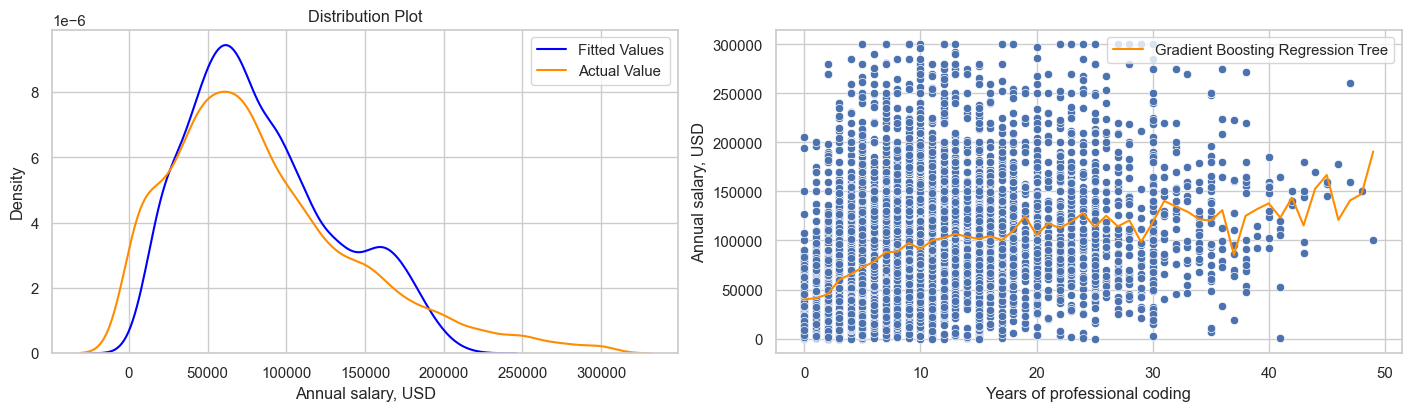

In [20]:
# fit a model
model_name = "Gradient Boosting Regression Tree"

model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# tunning hyperparameter 
parameters = {
    "max_iter": [1500, 2000, 2500, 3000],
    "max_leaf_nodes": [5, 10, 20],
    "learning_rate": [0.01]
    }
tuning = GridSearchCV(model, parameters, cv=5)
tuning.fit(X_train, y_train)

best_model = tuning.best_estimator_
print ("\nTuning parameters:")
print (tuning.best_score_, tuning.best_params_) 
R2_train = best_model.score(X_train, y_train)


# predict salary with the best trained model on the test data set
y_pred = best_model.predict(X_test)

RSS = ((y_test-y_pred)**2).sum()
TSS = ((y_train.mean()-y_test)**2).sum()
R2_test = 1.0 - RSS/TSS

# Evaluate model performance
ModelEvaluationVisualisation(df_test, y_test, y_pred, model_name,  R2_train, R2_test)

### Prediction Interval for Histogram Gradient Boosting Tree

In [21]:
tuning.best_params_

{'learning_rate': 0.01, 'max_iter': 2500, 'max_leaf_nodes': 20}

In [22]:
lower_bound_model = HistGradientBoostingRegressor(loss='quantile', 
                                                  quantile=0.1, 
                                                  max_iter= tuning.best_params_['max_iter'],
                                                  learning_rate=tuning.best_params_['learning_rate'], 
                                                  max_leaf_nodes=tuning.best_params_['max_leaf_nodes'])

upper_bound_model = HistGradientBoostingRegressor(loss='quantile', 
                                                  quantile=0.9, 
                                                  max_iter= tuning.best_params_['max_iter'],
                                                  learning_rate=tuning.best_params_['learning_rate'], 
                                                  max_leaf_nodes=tuning.best_params_['max_leaf_nodes'])

In [23]:
lower_bound_model.fit(X_train, y_train)

HistGradientBoostingRegressor(learning_rate=0.01, loss='quantile',
                              max_iter=2500, max_leaf_nodes=20, quantile=0.1)

In [24]:
upper_bound_model.fit(X_train, y_train)

HistGradientBoostingRegressor(learning_rate=0.01, loss='quantile',
                              max_iter=2500, max_leaf_nodes=20, quantile=0.9)

In [25]:
y_pred = best_model.predict(X_test)

In [26]:
y_pred_upper = upper_bound_model.predict(X_test)

In [27]:
y_pred_lower = lower_bound_model.predict(X_test)


Gradient Boosting Regression Tree

Model performance on train data R^2 = 0.676
Model performance on test data R^2 = 0.641


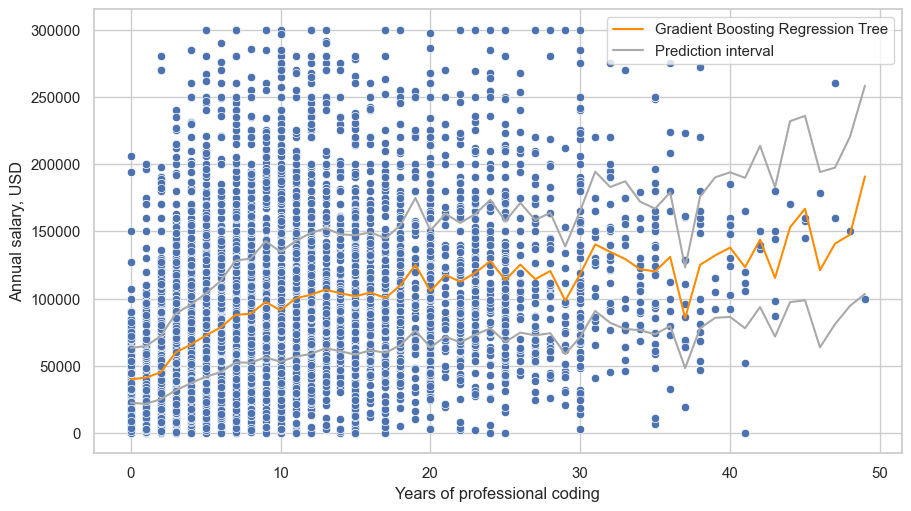

In [28]:
custom_params = {'axes.grid': True}
sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=0.98, color_codes=True, rc=custom_params)

# Evaluate model performance on test data
width = 9
height = 5

print(f'\n{model_name}\n')

print("Model performance on train data R^2 = {0:.3f}".format(R2_train))
print("Model performance on test data R^2 = {0:.3f}".format(R2_test))

fig, ax = plt.subplots(figsize=(width, height), constrained_layout=True)

sns.scatterplot(x=df_test["YearsCodePro"], y=y_test, ax=ax)
sns.lineplot(x=df_test["YearsCodePro"], y=y_pred, color="darkorange", label=model_name, ax=ax, errorbar= None)
sns.lineplot(x=df_test["YearsCodePro"], y=y_pred_upper, color="darkgrey", label='Prediction interval', ax=ax, errorbar= None)
sns.lineplot(x=df_test["YearsCodePro"], y=y_pred_lower, color="darkgrey", label=None, ax=ax, errorbar= None)

ax.set_ylabel("Annual salary, USD")
ax.set_xlabel("Years of professional coding")
ax.legend(title="")

fig.savefig('../graphs/salary_prediction.png', dpi=300)

plt.show()
plt.close()

In [29]:
test_point = {'EdLevel':'Master', 'YearsCodePro':'5', 'DevType':'Data scientist or machine learning specialist', 'Country':'Germany'}
test_point= pd.DataFrame(data=test_point, index=[0])

In [30]:
test_pls = ['Python', 'R', 'SQL']

pls_dict={}
for element in top20pls:            
        if element in test_pls:
            pls_dict[element] = 1
        else:
            pls_dict[element] = 0

pls_dict['Other'] = len( set(test_pls).difference(set(top20pls)) )

In [31]:
pls_test = pd.DataFrame(data=pls_dict, index=[0])

In [32]:
test_point = test_point.join(pls_test)
test_point = pipeline.transform(test_point)

In [33]:
y_pred = best_model.predict(test_point)
y_pred_upper = upper_bound_model.predict(test_point)
y_pred_lower = lower_bound_model.predict(test_point)

print('salary = {:.0f}'.format(y_pred[0]))
print('salary interval = [{:.0f}, {:.0f}]'.format(y_pred_lower[0], y_pred_upper[0]))

salary = 79255
salary interval = [52443, 93526]
